In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
from collections import namedtuple, deque
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, seed, n_hidden_1=256, n_hidden_2=128):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_dim, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return 2*torch.tanh(self.fc3(x))


class QNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, seed, n_hidden_1=256, n_hidden_2=128):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_dim, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1+action_dim, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, 1)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.001
LR_ACTOR = 0.001
LR_CRITIC = 0.01
WEIGHT_DECAY = 0


class DDPG():
    def __init__(self, state_size, action_size, random_seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.actor_local = PolicyNetwork(state_size, action_size, random_seed).to(device)
        self.actor_target = PolicyNetwork(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = QNetwork(state_size, action_size, random_seed).to(device)
        self.critic_target = QNetwork(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.noise = OUNoise(action_size, random_seed)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def execute_action(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.update_q_function_and_policy(experiences, GAMMA)

    def get_action(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -2, 2)

    def reset(self):
        self.noise.reset()

    def update_q_function_and_policy(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        #updating Q-function
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        #updating policy
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.update_target_networks(self.critic_local, self.critic_target, TAU)
        self.update_target_networks(self.actor_local, self.actor_target, TAU)

    def update_target_networks(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [16]:
env = gym.make('Pendulum-v1')
env.seed(2)
print('State shape: ', env.observation_space.shape)
print('Action shape: ', env.action_space.shape)
agent = DDPG(state_size=3, action_size=1, random_seed=0)

State shape:  (3,)
Action shape:  (1,)


In [17]:
n_epochs = 700
rewards = []
def train_ddpg():
    for i in range(1, n_epochs+1):
        state = env.reset()
        agent.reset()
        total_reward_in_epoch = 0
        for j in range(300):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.execute_action(state, action, reward, next_state, done)
            state = next_state
            total_reward_in_epoch += reward
            if done:
                break
        rewards.append(total_reward_in_epoch)
        if i % 10 == 0:
            print(f"Epoch {i}/{n_epochs}: Reward (Mean of last 10 epochs) =  {np.mean(rewards[-10:])}")
train_ddpg()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epoch 10/700: Reward (Mean of last 10 epochs) =  -1401.0114304609904
Epoch 20/700: Reward (Mean of last 10 epochs) =  -1477.902473477591
Epoch 30/700: Reward (Mean of last 10 epochs) =  -1312.0093308106746
Epoch 40/700: Reward (Mean of last 10 epochs) =  -1252.245994020706
Epoch 50/700: Reward (Mean of last 10 epochs) =  -1266.4325425040809
Epoch 60/700: Reward (Mean of last 10 epochs) =  -887.1129771277647
Epoch 70/700: Reward (Mean of last 10 epochs) =  -666.4442735803685
Epoch 80/700: Reward (Mean of last 10 epochs) =  -669.3842915196246
Epoch 90/700: Reward (Mean of last 10 epochs) =  -289.02942002929456
Epoch 100/700: Reward (Mean of last 10 epochs) =  -484.20008612030495
Epoch 110/700: Reward (Mean of last 10 epochs) =  -441.49909183329737
Epoch 120/700: Reward (Mean of last 10 epochs) =  -405.44750338045736
Epoch 130/700: Reward (Mean of last 10 epochs) =  -318.98203950518877
Epoch 140/700: Reward (Mean of last 10 epochs) =  -378.53746244665206
Epoch 150/700: Reward (Mean of las

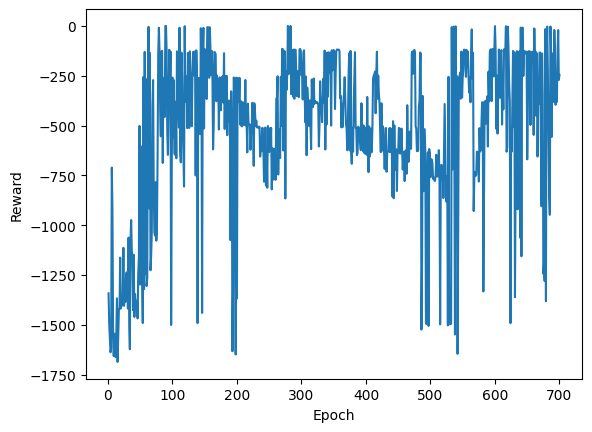

In [18]:
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('Reward')
plt.xlabel('Epoch')
plt.show()